<a href="https://colab.research.google.com/github/cfcastillo/DS-6-Notebooks/blob/main/Project_3_Notebook_cfc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition

The purpose of this project is to predict **new song popularity** (target) based on data features (variables) collected for songs that have been on the top 200 Weekly Global charts of Spotify in 2020 and 2021. [Project details](https://docs.google.com/document/d/1v73i9PjBgqlaW6YMCd76MYSc96q2fqNv/edit)

This is a **supervised regression** problem.

**Goals**

* To Minimize the cross-validated root mean squared error (RMSE) around 10.
* To determine the importance of the features in driving the regression result.
* To choose parameters that will avoid over-fitting in the result.

**Methodology**

The project will be done using tree-based regression techniques.

# Data Collection

The dataset includes all songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 and 2021. Below, is a link to the data description.

[Data Description](https://docs.google.com/document/d/14xiF2TXOGvbMbf5sxYQAwtXDlfrdPh_hxmeDHGCMH0E/edit)

## Imports

In [ ]:
# grab the imports needed for the project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

# all
from sklearn import datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import sklearn.model_selection as model_selection

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn import metrics  

# Visualization
import graphviz
from IPython.display import display
from sklearn import tree


In [ ]:
# Installs
!pip3 install dtreeviz
from dtreeviz.trees import dtreeviz

## Load Data

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
# Load Data
data_path = '/drive/My Drive/Cohort_6/Projects/Project 3/Data/Project_3_Spotify.csv'
data = pd.read_csv(data_path)

# Data Cleaning

In [ ]:
# View top 5 records - all columns
data.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,Release Date,Weeks Charted,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,100,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],2021-05-21,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,98,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,2021-07-23--2021-07-30,96,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [ ]:
# Any Nulls?
data.isnull().sum().sum()

0

In [ ]:
# Get a copy of the data before massaging the data.
data_clean = data.copy()

## Drop columns

Since the project requirement is to predict **new** song popularity, we will drop columns that would not be available for new songs. Additionally, we will drop columns that are not predictors, such as the row index and song id.

In [ ]:
# Drop indexes
data_clean.drop(['Index', 'Song ID'], inplace=True, axis=1)

# Drop features that would not exist for new songs
data_clean.drop(['Highest Charting Position', 'Number of Times Charted', 'Week of Highest Charting', 'Streams', 'Weeks Charted'], inplace=True, axis=1)

data_clean.tail()

,Song Name,Artist,Artist Followers,Genre,Release Date,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
1551,New Rules,Dua Lipa,27167675,"['dance pop', 'pop', 'uk pop']",2017-06-02,79,0.762,0.7,-6.021,0.0694,0.00261,0.153,116.073,209320,0.608,A
1552,Cheirosa - Ao Vivo,Jorge & Mateus,15019109,"['sertanejo', 'sertanejo universitario']",2019-10-11,66,0.528,0.87,-3.123,0.0851,0.24,0.333,152.37,181930,0.714,B
1553,Havana (feat. Young Thug),Camila Cabello,22698747,"['dance pop', 'electropop', 'pop', 'post-teen ...",2018-01-12,81,0.765,0.523,-4.333,0.03,0.184,0.132,104.988,217307,0.394,D
1554,Surtada - Remix Brega Funk,"Dadá Boladão, Tati Zaqui, OIK",208630,"['brega funk', 'funk carioca']",2019-09-25,60,0.832,0.55,-7.026,0.0587,0.249,0.182,154.064,152784,0.881,F
1555,Lover (Remix) [feat. Shawn Mendes],Taylor Swift,42227614,"['pop', 'post-teen pop']",2019-11-13,70,0.448,0.603,-7.176,0.064,0.433,0.0862,205.272,221307,0.422,G


## Fix Data Types

Some columns were imported as object data types but actually contain numeric values. These columns needed to be converted to their numerical equivalent as required by the XG Boost model.

In [ ]:
# Convert strings into numbers. Note: some are blank so using coerce will turn them into 
# NaN which can be removed later.

# Target data
data_clean['Popularity'] = pd.to_numeric(data_clean['Popularity'], errors='coerce')

# Feature data
data_clean['Artist Followers'] = pd.to_numeric(data_clean['Artist Followers'], errors='coerce')
data_clean['Danceability'] = pd.to_numeric(data_clean['Danceability'], errors='coerce')
data_clean['Energy'] = pd.to_numeric(data_clean['Energy'], errors='coerce')
data_clean['Loudness'] = pd.to_numeric(data_clean['Loudness'], errors='coerce')
data_clean['Speechiness'] = pd.to_numeric(data_clean['Speechiness'], errors='coerce')
data_clean['Acousticness'] = pd.to_numeric(data_clean['Acousticness'], errors='coerce')
data_clean['Liveness'] = pd.to_numeric(data_clean['Liveness'], errors='coerce')
data_clean['Tempo'] = pd.to_numeric(data_clean['Tempo'], errors='coerce')
data_clean['Duration (ms)'] = pd.to_numeric(data_clean['Duration (ms)'], errors='coerce')
data_clean['Valence'] = pd.to_numeric(data_clean['Valence'], errors='coerce')

# Convert date
data_clean['Release Date'] = pd.to_datetime(data_clean['Release Date'], errors='coerce')

In [ ]:
# Conversion produced some nulls for values that could not be converted. Remove these rows
# since all predictors in these rows are null.
data_clean = data_clean.dropna()
print(data_clean.isna().sum())

Song Name           0
Artist              0
Artist Followers    0
Genre               0
Release Date        0
Popularity          0
Danceability        0
Energy              0
Loudness            0
Speechiness         0
Acousticness        0
Liveness            0
Tempo               0
Duration (ms)       0
Valence             0
Chord               0
dtype: int64


In [ ]:
# Verify final data types
data_clean.dtypes

Song Name                   object
Artist                      object
Artist Followers           float64
Genre                       object
Release Date        datetime64[ns]
Popularity                 float64
Danceability               float64
Energy                     float64
Loudness                   float64
Speechiness                float64
Acousticness               float64
Liveness                   float64
Tempo                      float64
Duration (ms)              float64
Valence                    float64
Chord                       object
dtype: object

## Feature Engineering

In this step, character data and columns containing multiple values were split and encoded so they could be modeled. Below are links to resources used for feature engineering.

[Techniques](https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114)

[Encoding Notebook](https://colab.research.google.com/drive/10mMFd3bsO7Gy8MbYY56Ukv8lg0-PCBmc)

[Imputation Notebook](https://colab.research.google.com/drive/1pq84SRJTOXSdKN9j9g6pORrKtIuQomhH)

[Lambda Examples](https://colab.research.google.com/drive/1jz5eSsPq2m1Onq492yKx0-oNO2UofiHR)

[SK Learn One Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)

[SK Learn Multi Label Binarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html)

In [ ]:
# Create label encoders instances
le = LabelEncoder()
mlb = MultiLabelBinarizer()
mlb2 = MultiLabelBinarizer()  # second instance to handle more condensed genre features

In [ ]:
# Genre processing functions
# Initial Genre cleaning before groupings

# Preprocessing for first genre splitting which is less condensed.
def genrePreProcessing1(df):
  genrePreProcessingAll(df)

  # Use regex to identify and remove specified characters so friendly column names can be generated when encoded.
  df['Genre'] = df['Genre'].str.replace(r"[\[\]'\-\&\+\s]", '', regex=True)

  # Turn Genre column into lists by splitting on comma.
  data_clean_enc['Genre'] = data_clean_enc['Genre'].str.split(',')

# Preprocessing for second genre splitting which will be more condensed.
def genrePreProcessing2(df):
  genrePreProcessingAll(df)

  # Use regex to identify and remove specified characters so friendly column names can be generated when encoded.
  df['Genre'] = df['Genre'].str.replace(r"[\[\]'\-\&\+\,]", '', regex=True)

# Preprocessing for all genre splitting.
def genrePreProcessingAll(df):
  # Combine some values to create categories.
  df['Genre'] = df['Genre'].str.replace('hip hop','hiphop')

  # Fill in blank genre. Blank genre will show as []
  df['Genre'] = df['Genre'].str.replace('\[\]','unknown')

# Do some final cleaning for Genre
def genrePostProcessing(df):
  # HACK! FILL NAN WITH ZERO FOR NOW SINCE DON'T KNOW WHAT IS CAUSING THIS ANOMALY
  df.fillna(0, inplace=True)

  # Remove unencoded column
  df.drop(['Genre'], inplace=True, axis=1)

In [ ]:
# THIS PRODUCES NULLS IN LAST 11 ROWS AND MAKES ALL ENCODED VALUES INTO FLOATS INSTEAD OF INTEGERS!!!!
# Encode Genre - one hot encode
data_clean_enc = data_clean.copy()

genrePreProcessing1(data_clean_enc)

# Use multi label binarizer to transform the Genre column into individual columns
# ALERT: THIS LINE IS CREATING NULL VALUES ON ALL GENRE FEATURE COLUMNS FOR LAST 11 ROWS ONLY. NOT SURE WHY.
data_clean_enc = data_clean_enc.join(pd.DataFrame(mlb.fit_transform(data_clean_enc['Genre']),columns=mlb.classes_))

genrePostProcessing(data_clean_enc)

In [ ]:
data_clean.head()

,Song Name,Artist,Artist Followers,Genre,Release Date,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,Beggin',Måneskin,3377762.0,"['indie rock italiano', 'italian pop']",2017-12-08,100.0,0.714,0.800,-4.808,0.0504,0.1270,0.3590,134.002,211560.0,0.589,B
1,STAY (with Justin Bieber),The Kid LAROI,2230022.0,['australian hip hop'],2021-07-09,99.0,0.591,0.764,-5.484,0.0483,0.0383,0.1030,169.928,141806.0,0.478,C#/Db
2,good 4 u,Olivia Rodrigo,6266514.0,['pop'],2021-05-21,99.0,0.563,0.664,-5.044,0.1540,0.3350,0.0849,166.928,178147.0,0.688,A
3,Bad Habits,Ed Sheeran,83293380.0,"['pop', 'uk pop']",2021-06-25,98.0,0.808,0.897,-3.712,0.0348,0.0469,0.3640,126.026,231041.0,0.591,B
4,INDUSTRY BABY (feat. Jack Harlow),Lil Nas X,5473565.0,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,96.0,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000.0,0.894,D#/Eb


In [ ]:
# Grab fresh dataset to be used for different encoding process.
data_clean_enc2 = data_clean.copy()

genrePreProcessing2(data_clean_enc2)

# Use multi label binarizer to transform the Genre column into individual columns
# Group Genre values more to reduce columns - reduced from 350 to 308. More grouping needed.
# Create unique lists for genre. i.e. italian pop, pop will become italian and pop
data_clean_enc2['Genre'] = data_clean_enc2['Genre'].apply(lambda x: np.unique(x.split()))
data_clean_enc2 = data_clean_enc2.join(pd.DataFrame(mlb2.fit_transform(data_clean_enc2['Genre']),columns=mlb2.classes_))

genrePostProcessing(data_clean_enc2)

# If using this grouping, then get copy to override previous methodology.
data_clean_enc = data_clean_enc2.copy()

In [ ]:
# Export feature columns to Excel to examine how to further group them since 
# Grouping #2 is still resulting in over 300 columns.
# file_name = "test.xlsx"
# data_clean_enc.sum().to_excel(file_name)

In [ ]:
# Manually combine genres that are similar
data_clean_enc['urban'] = data_clean_enc['urbaine'] + data_clean_enc['urban'] + data_clean_enc['urbano']
data_clean_enc.drop(['urbaine', 'urbano'], axis=1, inplace=True)

data_clean_enc['alternative'] = data_clean_enc['alternative'] + data_clean_enc['alt']
data_clean_enc.drop(['alt'], axis=1, inplace=True)

data_clean_enc['argentino'] = data_clean_enc['argentino'] + data_clean_enc['argentine']
data_clean_enc.drop(['argentine'], axis=1, inplace=True)

data_clean_enc['colombiano'] = data_clean_enc['colombiano'] + data_clean_enc['colombian']
data_clean_enc.drop(['colombian'], axis=1, inplace=True)

data_clean_enc['electro'] = data_clean_enc['electro'] + data_clean_enc['electropop'] + data_clean_enc['electronic']
data_clean_enc.drop(['electropop', 'electronic'], axis=1, inplace=True)

data_clean_enc['hiphop'] = data_clean_enc['hiphop'] + data_clean_enc['hip']
data_clean_enc.drop(['hip'], axis=1, inplace=True)

data_clean_enc['italian'] = data_clean_enc['italian'] + data_clean_enc['italiana'] + data_clean_enc['italiano']
data_clean_enc.drop(['italiana', 'italiano'], axis=1, inplace=True)

data_clean_enc['latino'] = data_clean_enc['latino'] + data_clean_enc['latin'] + data_clean_enc['latina']
data_clean_enc.drop(['latin', 'latina'], axis=1, inplace=True)

data_clean_enc['puertorican'] = data_clean_enc['puerto'] + data_clean_enc['rican']
data_clean_enc.drop(['puerto', 'rican'], axis=1, inplace=True)

# View totals again to determine list to keep and which ones to throw into "other" group
# These columns will be retained further down at the beginning of the EDA.
genres_to_keep = ['pop','rap','hiphop','trap','latino','dance','postteen','reggaeton','melodic','canadian','electro',
                  'uk','rb','rock','house','colombiano','german','atl','group','kpop','edm','chicago','alternative','drill',
                  'tropical','boy','contemporary']


In [ ]:
# Since some songs have multiple artists, pull out the first artist in the column 
# since this is likely the lead artist and thus more important for predicting song success.
data_clean_enc['Artist'] = data_clean_enc['Artist'].apply(lambda x: x.split(',')[0])

# Now encode.
data_clean_enc['Artist Lb'] = le.fit_transform(data_clean_enc['Artist'])

# Remove unencoded column
data_clean_enc.drop(['Artist'], inplace=True, axis=1)

In [ ]:
# TODO: Encode song name. WILL DO AT SOME FUTURE DATE.
# First remove data about featured artists and remix - anything in parenthesis or square brackets.
# Then remove dashes
# data_clean_enc['Song Name']

data_clean_enc.drop(['Song Name'], inplace=True, axis=1)

In [ ]:
# Encode chord
data_clean_enc['Chord Lb'] = le.fit_transform(data_clean_enc['Chord'])
data_clean_enc[['Chord Lb', 'Chord']]

# Remove unencoded column
data_clean_enc.drop(['Chord'], inplace=True, axis=1)

In [ ]:
# Split release date into month, day, day of week to see if release date has impact on popularity.
data_clean_enc['Release Month'] = data_clean_enc['Release Date'].dt.month
data_clean_enc['Release Day'] = data_clean_enc['Release Date'].dt.day
data_clean_enc['Release Weekday'] = data_clean_enc['Release Date'].dt.dayofweek # Assumes week starts on Monday
# Verify results
data_clean_enc[['Release Date', 'Release Month', 'Release Day', 'Release Weekday']]

# Remove Release Date because model cannot use dates. Model will use date parts instead.
data_clean_enc.drop(['Release Date'], inplace=True, axis=1)

In [ ]:
# Final data review to see what else needs to be done
data_clean_enc.head()
# print(data_clean_enc.shape)

,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,150,a,acoustic,adult,advocacy,african,afrofuturism,afroswing,albanian,album,alternative,american,argentino,art,atl,aussietronica,australian,baiano,band,banda,basshall,beatlesque,bedroom,belge,belgian,bh,big,boricua,boston,...,swing,synthpop,talent,techno,tekk,tennessee,tonlist,torch,toronto,touch,trance,trancecore,trap,triste,tropical,tunes,turkish,uk,underground,universitario,unknown,urban,vancouver,vapor,vegas,venezolano,venezuelan,viral,vocal,wave,weirdcore,west,yacht,z,puertorican,Artist Lb,Chord Lb,Release Month,Release Day,Release Weekday
0,3377762.0,100.0,0.714,0.800,-4.808,0.0504,0.1270,0.3590,134.002,211560.0,0.589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,331,2,12,8,4
1,2230022.0,99.0,0.591,0.764,-5.484,0.0483,0.0383,0.1030,169.928,141806.0,0.478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,451,4,7,9,4
2,6266514.0,99.0,0.563,0.664,-5.044,0.1540,0.3350,0.0849,166.928,178147.0,0.688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,353,0,5,21,4
3,83293380.0,98.0,0.808,0.897,-3.712,0.0348,0.0469,0.3640,126.026,231041.0,0.591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141,2,6,25,4
4,5473565.0,96.0,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000.0,0.894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,261,6,7,23,4


# Exploratory Data Analysis (EDA)

* Get correlations on continuous variables
 * Artist Followers
 * Danceability
 * Energy
 * Loudness
 * Speechiness
 * Acousticness
 * Liveness
 * Tempo
 * Duration (ms)
 * Valence
 * Release Month, Day, Weekday
* TODO: Get average popularity across genres


In [ ]:
# Get lists of columns that can be used for further analysis
continuous_cols = ['Artist Followers','Danceability','Energy','Loudness','Speechiness','Acousticness','Liveness','Tempo',
                  'Duration (ms)','Valence']
other_cols = ['Artist Lb','Chord Lb']
release_date_cols = ['Release Month','Release Day','Release Weekday']
non_genre_cols = continuous_cols + other_cols + release_date_cols + ['Popularity']
cols_to_keep = non_genre_cols + genres_to_keep

## Histograms - Continuous Variables

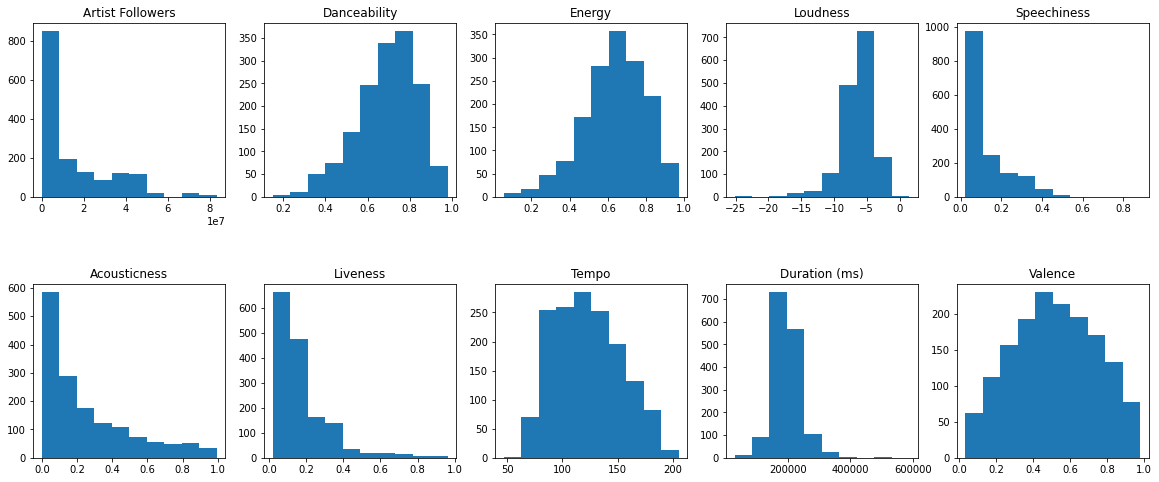

In [ ]:
# Get continuous variables into a dataframe for analysis
data_eda_cnt = data_clean_enc[continuous_cols].copy()

# Get histograms of continuous variables to note biases in the data.
across = 5
down = 2
fig, axs = plt.subplots(down,across, figsize = (20,8))
plt.subplots_adjust(hspace=.5)

n = 0
for i in range(down): #loop rows
  for j in range(across): #loop cols
    if n < data_eda_cnt.shape[1]: #safety to avoid array out of bounds error - don't exceed number of cols
      col = data_eda_cnt.columns[n]
      axs[i,j].hist(data_eda_cnt[col])
      axs[i,j].set_title(col)
      n+=1

In [ ]:
# Get stats on continuous variables
data_eda_cnt.describe()

,Artist Followers,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence
count,1.545000e+03,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000
mean,1.471690e+07,0.689997,0.633495,-6.348474,0.123656,0.248695,0.181202,122.811023,197940.816828,0.514704
std,1.667579e+07,0.142444,0.161577,2.509281,0.110383,0.250326,0.144071,29.591088,47148.930420,0.227326
min,4.883000e+03,0.150000,0.054000,-25.166000,0.023200,0.000025,0.019700,46.718000,30133.000000,0.032000
25%,2.123734e+06,0.599000,0.532000,-7.491000,0.045600,0.048500,0.096600,97.960000,169266.000000,0.343000
50%,6.852509e+06,0.707000,0.642000,-5.990000,0.076500,0.161000,0.124000,122.012000,193591.000000,0.512000
75%,2.269875e+07,0.796000,0.752000,-4.711000,0.165000,0.388000,0.217000,143.860000,218902.000000,0.691000
max,8.333778e+07,0.980000,0.970000,1.509000,0.884000,0.994000,0.962000,205.272000,588139.000000,0.979000


### Observations

* **Artist Followers** is negatively skewed indicating that many newly released songs do not have very many followers. 

* **Danceability and energy** are positively skewed indicating that many new songs are high energy.

* **Loudness** is measured in Loudness Units Relative to Full Scale (LUFS). The value provided in the file is the adjustment that was applied to bring the decibels down to the same -14 LUFS value so that a listener can avoid large fluctions in loudness from song to song. Therefore a large negative means the song was much louder so that it had to be adjusted down more to get within Spotify's desired range. In looking at the data, it is apparant that most songs required some adjustment.

* **Speechiness** indicates how many spoken words are on a track. High speechiness indicates the song is mostly spoken words. Smaller numbers indicate new songs are more musical with fewer words.

* **Valence** indicates music positivity. A higher valence indicates the music is more positive or cheerful whereas a lower valence indicates the song is more negative, sad, angry, or depressed. The new song list valence is normally distributed indicating songs are pretty neutral in this area.

* **Liveness** indicates the presence of an audience in the music. This value is negatively skewed indicating most songs were performed in studio without a live audience.

* **Acousticness** indicates how much electrical amplification is in a song. Smaller numbers show that a large number of new songs are more natural in sound using less electrical amplification. 

* **Song duration** is normally distributed with most songs running around 3 minutes.

* **Tempo** is normally distributed with most songs having a beat between 100 and 150 beats per minute. Here are some [common tempos by genre](https://learningmusic.ableton.com/make-beats/tempo-and-genre.html):
  * Dub: 60-90 bpm.
  * Hip-hop: 60-100 bpm.
  * House: 115-130 bpm.
  * Techno/trance: 120-140 bpm.
  * Dubstep: 135-145 bpm.
  * Drum and bass: 160-180 bpm

## Pie Charts - Categorical Variables

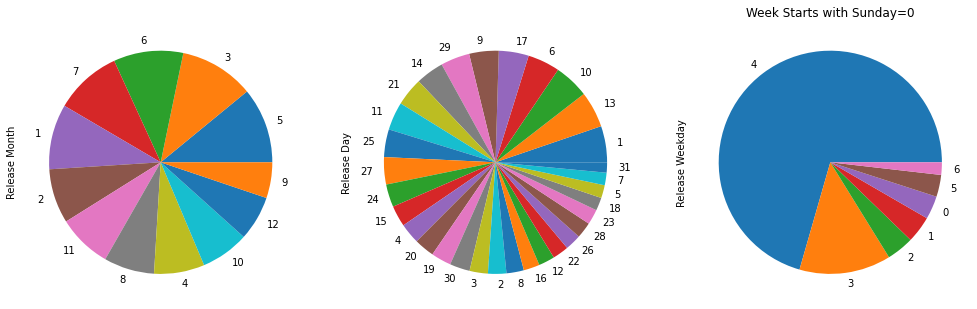

In [ ]:
# Get continuous variables into a dataframe for analysis
data_eda_rlse = data_clean_enc[release_date_cols].copy()

# Show pie plots to observe value distribution
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (17,14))
plt.subplots_adjust(hspace=.25)

data_eda_rlse['Release Month'].value_counts().plot.pie(ax=ax1)
data_eda_rlse['Release Day'].value_counts().plot.pie(ax=ax2)
data_eda_rlse['Release Weekday'].value_counts().plot.pie(ax=ax3, title='Week Starts with Sunday=0')


### Observations

Release Month and Release Day are pretty evenly distributed. However, **weekday for release is significantly higher for Wednesday and Thursday** indicating that a successful release should be on one of those two days.

## Correlations Between Predictors

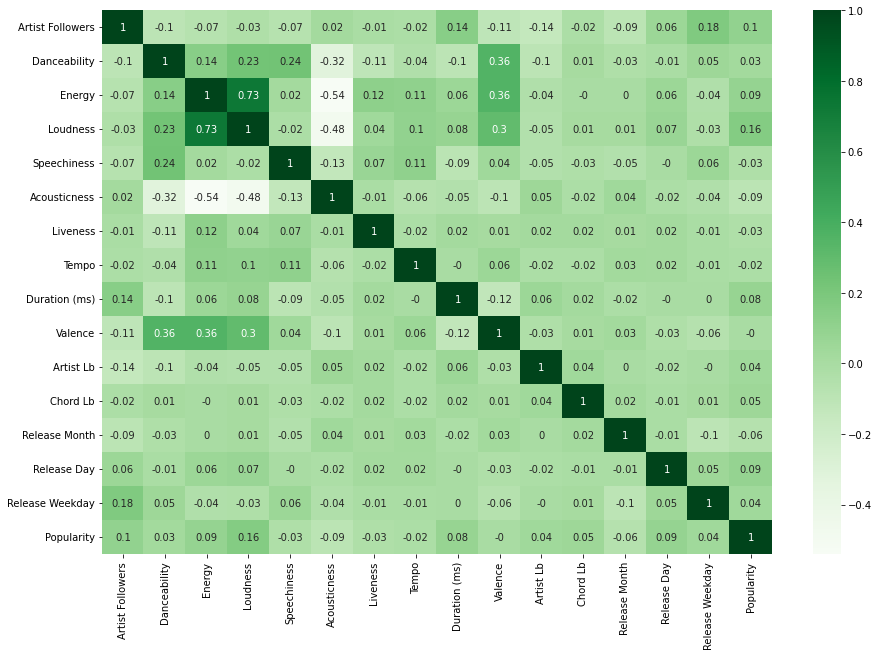

In [ ]:
# Correlations between variables - non-genre
data_eda_corr = data_clean_enc[non_genre_cols].copy()

plt.figure(figsize=(15,10))
correlation_matrix = data_eda_corr.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='Greens')

### Observations

* Energy and Loudness were highly correlated indicating high loudness resulted in high energy.

* Valence showed moderate correlation with Danceability, Energy, and Loudness indicating that positive songs might also have high danceability, energy, and loudness. 

* Acousticness was negatively correlated with Danceability, Energy, and Loudness indicating more natural sounds did not contribute to these three categories.

* All other correlations were modest indicating other variables were more independent.

## Correlations with Popularity

In [ ]:
# Correlations between target and predictors to see which predictors have a linear correlation with Popularity.
corr = data_eda_corr.corr()['Popularity'].round(3)
correlated_vars = abs(corr).sort_values(ascending=False)
correlated_vars

Popularity          1.000
Loudness            0.159
Artist Followers    0.104
Energy              0.095
Acousticness        0.091
Release Day         0.090
Duration (ms)       0.082
Release Month       0.064
Chord Lb            0.046
Release Weekday     0.041
Artist Lb           0.041
Speechiness         0.032
Liveness            0.029
Danceability        0.028
Tempo               0.025
Valence             0.001
Name: Popularity, dtype: float64

### Observations

Looking at linear correlations between Popularity (target) and the predictor columns indicates that there is **very little correlation between predictors and the target** indicating that a more complex relationship exists between the predictors and target. Therefore, further analysis will need to be done to determine how the predictors will affect song Popularity.

# Processing

[Decision Trees Notebook](https://colab.research.google.com/drive/1VemtU48HSaw8l70PCYNtMSWYjIAkZ05B)

[Random Forest Notebook](https://colab.research.google.com/drive/1eovGCLgqtIIOIpqGqTmOVmgpTOaRBlvN)

[XG Boost Notebook](https://colab.research.google.com/drive/1N2T8cBBQMQzJMklUjCNicu--IBVcmUFh)

### Prepare Test Data

In [505]:
# Create new dataset that contains the columns we want to keep for our analysis.
# data_final = data_clean_enc[cols_to_keep].copy()
data_final = data_clean_enc[non_genre_cols].copy()

# Break up data into training and testing sets
X = data_final.drop(['Popularity'], axis = 1).copy()
y = data_final['Popularity']

# Get target and feature names for visualizations
target_name = 'Popularity'
feature_names = X.columns.to_list()

# List parameters to be used in all models
test_size = 0.2

## Decision Tree

In [506]:
# Number of iterations for cross validation
# Loop of 10 produces inconsistent results. 
# Anything over 50 produces optimal max depth between 5 and 7 - numbers are very close for all three.
num_loops = 200

# Try different max depth for each CV test.
max_depth = [1, 2, 3, 4, 5, 6, 7, 8]
rms_depth = np.zeros(len(max_depth))

for n, depth in enumerate(max_depth):
  # Storage for each result so we can get mean from all iterations.
  rmse_results = np.zeros(num_loops)
  for idx in range(0,num_loops):
    # Create train and test data sets.
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)
    # Configure model
    model_dt = DecisionTreeRegressor(max_depth=depth, random_state=0) 
    model_dt.fit(X_train,y_train)
    y_pred_dt = model_dt.predict(X_test)
    rmse_results[idx] = np.sqrt(mean_squared_error(y_test, y_pred_dt))

  # Record RMSE by depth to find optimal depth
  rms_depth[n] = rmse_results.mean().round(3)

# Print result so we can see which depth provided best RMSE
print(f"CV RMSE by Depth:\n")
for n, depth in enumerate(max_depth):
  print(f'Depth={max_depth[n]} | RMSE={rms_depth[n]}')
  if rms_depth[n] == rms_depth.min():
    optimal_depth = max_depth[n]
    optimal_rmse = rms_depth[n]
    print(f'Optimal Depth={optimal_depth}')

CV RMSE by Depth:

Depth=1 | RMSE=15.265
Depth=2 | RMSE=11.115
Depth=3 | RMSE=10.656
Depth=4 | RMSE=10.619
Optimal Depth=4
Depth=5 | RMSE=10.711
Depth=6 | RMSE=10.764
Depth=7 | RMSE=11.109
Depth=8 | RMSE=11.469


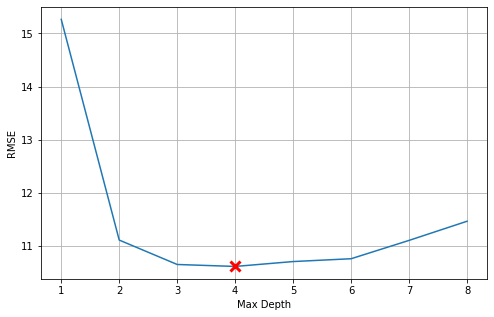

In [507]:
# Plot result of max depth showing optimal depth.
plt.figure(figsize = (8,5))
plt.plot(max_depth, rms_depth)
plt.plot(optimal_depth,optimal_rmse,'rx', markersize=10, markeredgewidth=3) 
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.grid()

In [508]:
# Train model with optimal max depth
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)
model_dt = DecisionTreeRegressor(max_depth=optimal_depth, random_state=0) 
model_dt.fit(X_train,y_train)
y_pred_dt = model_dt.predict(X_test)
rms_error = np.sqrt(mean_squared_error(y_test, y_pred_dt))

print(f"Optimal RMSE: {rms_error.round(2)}")

Optimal RMSE: 10.29


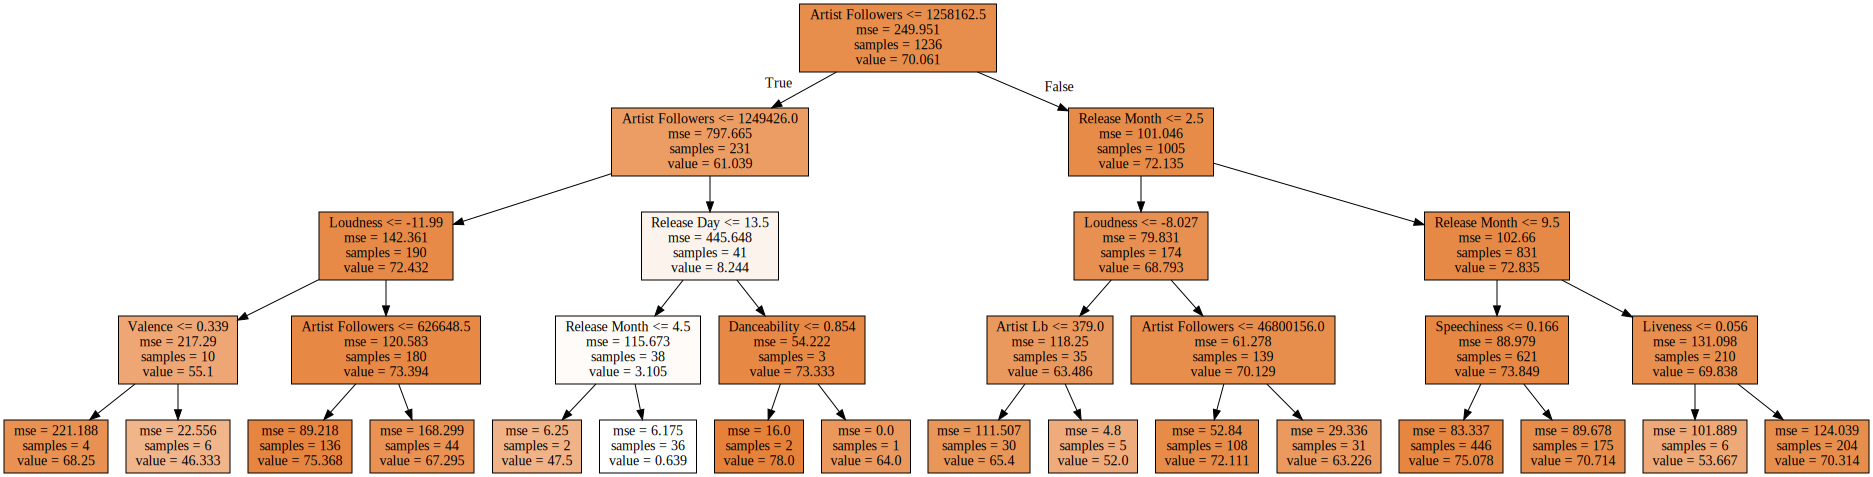

In [509]:
# Show Tree
display(graphviz.Source(tree.export_graphviz(model_dt, feature_names=feature_names, filled = True)))

In [510]:
# Visualize using dtreeviz 
# This plot is very small making it hard to read. Commenting out for now.
# dtreeviz(model_dt, X_train, y_train, target_name=target_name, feature_names=feature_names)

## Random Forest

In [511]:
# Number of iterations for cross validation
# Loop of 10 produces inconsistent results. 
# Anything over 50 produces optimal max depth between 5 and 7 - numbers are very close for all three.
num_loops = 200

# Try different number of trees - go from min to max in steps
# num_trees = range(min, max, steps)
num_trees = range(10, 70, 10)
rms_trees = np.zeros(len(num_trees))

for n, trees in enumerate(num_trees):
  # Storage for each result so we can get mean from all iterations.
  rmse_results = np.zeros(num_loops)
  for idx in range(0,num_loops):
    # Create train and test data sets.
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)
    # Configure model. Use optimal depth gained in Decision Tree above.
    model_rf = RandomForestRegressor(n_estimators=trees, max_depth=optimal_depth, random_state=0)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    rmse_results[idx] = np.sqrt(mean_squared_error(y_test, y_pred_rf))

  # Record RMSE by depth to find optimal depth
  rms_trees[n] = rmse_results.mean().round(3)

# Print result so we can see which tree count provided best RMSE
print(f"CV RMSE by Tree Count:\n")
for n, trees in enumerate(num_trees):
  print(f'Trees={num_trees[n]} | RMSE={rms_trees[n]}')
  if rms_trees[n] == rms_trees.min():
    optimal_trees = num_trees[n]
    optimal_rmse = rms_trees[n]
    print(f'Optimal Trees={optimal_trees}')

CV RMSE by Tree Count:

Trees=10 | RMSE=10.34
Trees=20 | RMSE=10.255
Trees=30 | RMSE=10.176
Optimal Trees=30
Trees=40 | RMSE=10.204
Trees=50 | RMSE=10.297
Trees=60 | RMSE=10.238


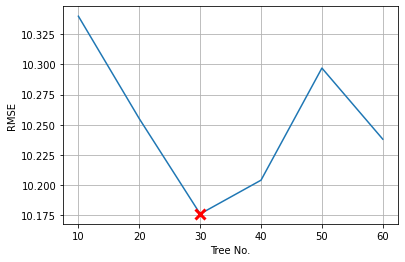

In [512]:
# Visualize result of optimal number of trees.
plt.plot(num_trees, rms_trees)
plt.plot(optimal_trees,optimal_rmse,'rx', markersize=10, markeredgewidth=3) 
plt.xlabel('Tree No.')
plt.ylabel('RMSE')
plt.grid()

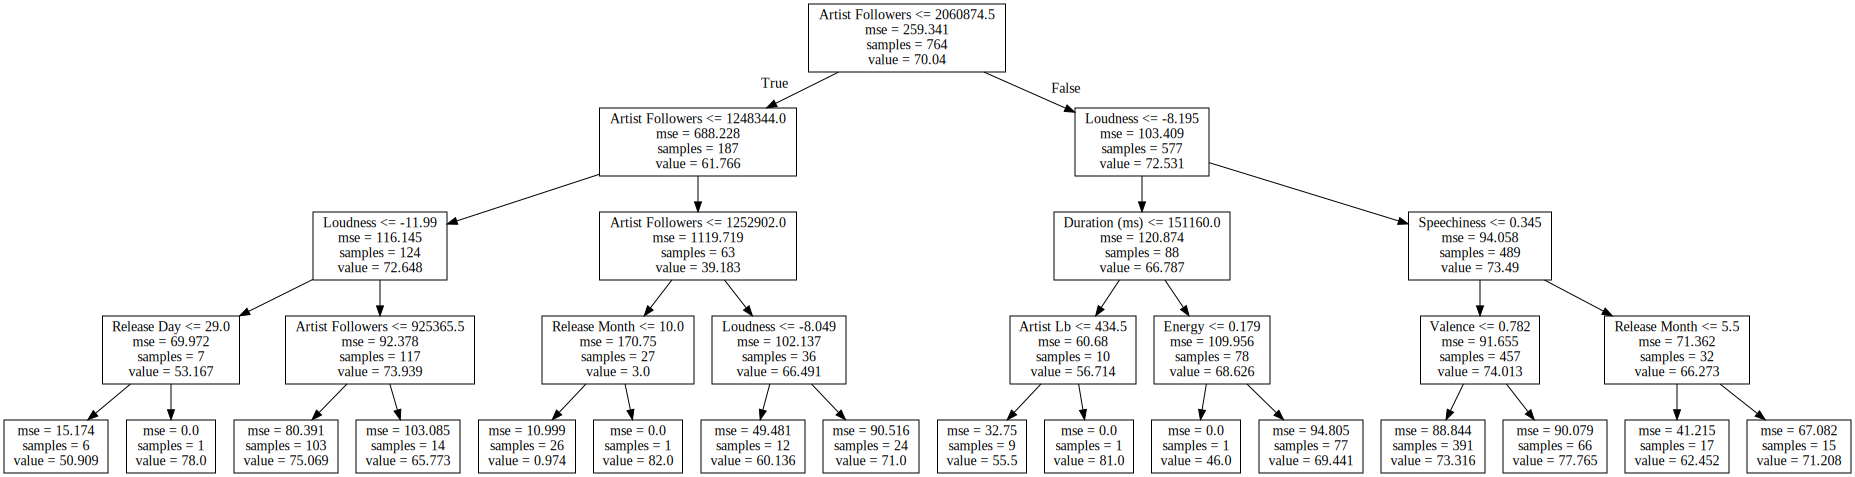

In [513]:
# Display one tree from the random forest
display(graphviz.Source(tree.export_graphviz(model_rf.estimators_[0], feature_names=feature_names)))

## XG Boost

### CV With No Parameters

In [514]:
# XG Boost - returns mse, not rmse. So need to take sqrt of result at end.
num_loops = 200
rmse_xgb  = np.zeros(num_loops)

for idx in range(0,num_loops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)
  model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0, seed = 10)
  model_xgb.fit(X_train,y_train)
  y_pred_xgb = model_xgb.predict(X_test)
  rmse_xgb[idx] = np.sqrt(mean_squared_error(y_test,y_pred_xgb))

print(f'CV RMSE XG Boost: {rmse_xgb.mean()}')

CV RMSE XG Boost: 9.962185854011688


Text(0, 0.5, 'Feature Importance Score')

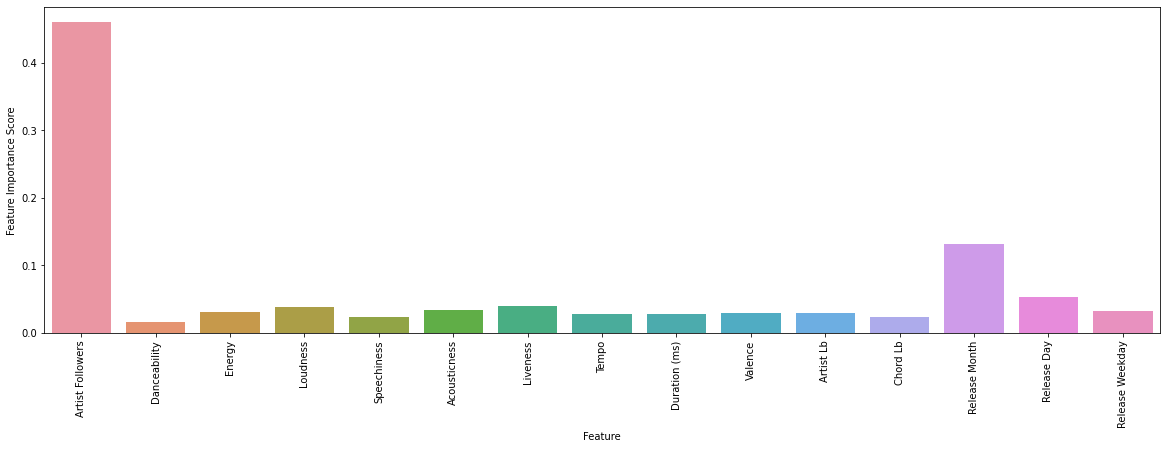

In [515]:
# View feature importance score so we know which features are contributing to the outcome
feat_imp = pd.Series(model_xgb.feature_importances_, index=X.columns)

# get rid of NaN and zero feature importance
feat_imp.dropna(inplace=True)
feat_imp.drop(feat_imp[feat_imp.values == 0].index, inplace=True)

plt.figure(figsize = (20,6))
ax = sns.barplot(x = feat_imp.index, y = feat_imp.values)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score')

### CV With Optimized Parameters

In [516]:
# Specify the parameters you want to try and their ranges. 
# small learning rate may require more estimators...
# max_depth = tree depth
# learning_rate = 
# n_estimators = number of trees
param_test = {
 'max_depth':[4,5,6,7,8],
 'learning_rate' : [0.1, 0.2, 0.3, 0.4], 
 'n_estimators': [30,40,50,60,70]
}

# Perform the grid search
# Allows us to specify multiple parameters for CV from parameter dictionaries.
gsearch = GridSearchCV(estimator = xgb.XGBRegressor(objective = 'reg:squarederror', seed = 10), 
                        param_grid = param_test, scoring='neg_mean_squared_error', cv=5)

# Fit to training data 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)
model_xgb_grid = gsearch.fit(X_train,y_train)

# Save results to variables for use in next step
best_learning_rate = model_xgb_grid.best_params_['learning_rate']
best_max_depth = model_xgb_grid.best_params_['max_depth']
best_n_estimators = model_xgb_grid.best_params_['n_estimators']

# see grid search results
print(model_xgb_grid.best_params_)


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 70}


In [517]:
# Try out the optimal parameters
numLoops = 200
rmse_xgb_grid  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)
  model_xgb_grid = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0, 
                          learning_rate = best_learning_rate, 
                          max_depth = best_max_depth, 
                          n_estimators = best_n_estimators, seed = 10)
  model_xgb_grid.fit(X_train,y_train)
  y_pred_xgb_grid = model_xgb_grid.predict(X_test)
  rmse_xgb_grid[idx] = np.sqrt(mean_squared_error(y_test,y_pred_xgb_grid))

print(f'CV RMSE XG Boost Grid: {rmse_xgb_grid.mean()}')

CV RMSE XG Boost Grid: 9.686278858183726


Text(0, 0.5, 'Feature Importance Score')

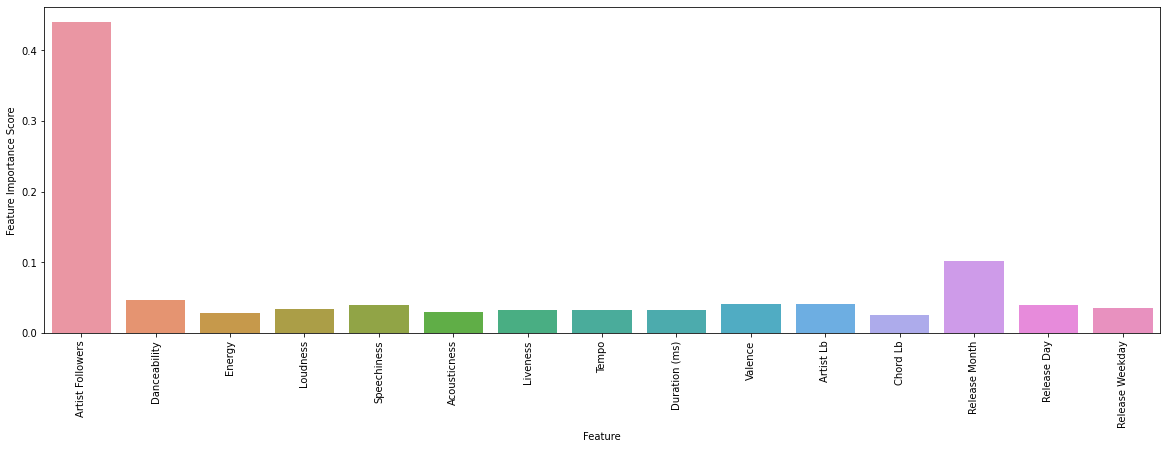

In [518]:
# View feature importance score so we know which features are contributing to the outcome
feat_imp = pd.Series(model_xgb_grid.feature_importances_, index=X.columns)

# get rid of NaN and zero feature importance
feat_imp.dropna(inplace=True)
feat_imp.drop(feat_imp[feat_imp.values == 0].index, inplace=True)

plt.figure(figsize = (20,6))
ax = sns.barplot(x = feat_imp.index, y = feat_imp.values)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score')

# Conclusions